# The Best Classifier
## Objective: Analyzing historical loan dataset and classifying with k-NN, Decision tree, SVM, logsitic regression. Then comparing the accuracy by metrics; jaccard index, logloss, F1 score.
### Deniz Aytemiz

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-12-19 13:35:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.07s   

2020-12-19 13:35:02 (303 KB/s) - ‘loan_train.csv’ saved [23101/23101]



In [33]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


## In order decide feature set lets analyze which gender has paidoff status, or distribution of paidoff status with respect to education levels

## 86% of woman and 73% of man has paidoff status

In [4]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

In [5]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)


education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

## converting to data time object for further analysis

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [7]:
df['dayofweek'] = df['effective_date'].dt.dayofweek

## To dataframe we are adding number of the day loan is obtained

In [8]:
df

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4
...,...,...,...,...,...,...,...,...,...,...,...
341,394,394,COLLECTION,800,15,2016-09-11,2016-09-25,32,High School or Below,male,6
342,395,395,COLLECTION,1000,30,2016-09-11,2016-10-10,25,High School or Below,male,6
343,397,397,COLLECTION,800,15,2016-09-12,2016-09-26,39,college,male,0
344,398,398,COLLECTION,1000,30,2016-09-12,2016-11-10,28,college,male,0


In [9]:
df.groupby(['dayofweek'])['loan_status'].value_counts(normalize=True)

dayofweek  loan_status
0          PAIDOFF        0.965517
           COLLECTION     0.034483
1          PAIDOFF        1.000000
2          PAIDOFF        1.000000
3          PAIDOFF        1.000000
4          COLLECTION     0.500000
           PAIDOFF        0.500000
5          PAIDOFF        0.548387
           COLLECTION     0.451613
6          PAIDOFF        0.608434
           COLLECTION     0.391566
Name: loan_status, dtype: float64

## One can observe, after day 4 chances of collection increases

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## We are adding this variable as binary varibale to weekend column. If loan is taken in day 4 or more the variable is 1, 0 otherwise

In [18]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## To feature matrix for classification, we add education levels as independent columns with dummy variables 

In [19]:
Feature_Matrix = df[['Principal','terms','age','Gender','weekend']]
Feature_Matrix = pd.concat([Feature_Matrix,pd.get_dummies(df['education'])], axis=1)
Feature_Matrix.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


## Now from loan_status column we take labels and save them in numpy array. PAIDOFF variable is set to 1 and COLLECTION is set to 0

In [35]:
y=df['loan_status']
y

0         PAIDOFF
1         PAIDOFF
2         PAIDOFF
3         PAIDOFF
4         PAIDOFF
          ...    
341    COLLECTION
342    COLLECTION
343    COLLECTION
344    COLLECTION
345    COLLECTION
Name: loan_status, Length: 346, dtype: object

In [36]:
y.replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0], inplace=True)
y

0      1
1      1
2      1
3      1
4      1
      ..
341    0
342    0
343    0
344    0
345    0
Name: loan_status, Length: 346, dtype: int64

In [41]:
y = df['loan_status'].to_numpy()
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [42]:
X=Feature_Matrix

## Feature matrix, standardized for more accurate metric

In [43]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X

array([[ 0.51578458,  0.92071769,  2.33152555, ...,  1.13639374,
        -0.07624929, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148, ..., -0.87997669,
        -0.07624929, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, ..., -0.87997669,
        -0.07624929,  1.14984679],
       ...,
       [-1.31458942, -0.95911111,  1.33661351, ..., -0.87997669,
        -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188, ..., -0.87997669,
        -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.81902922, ..., -0.87997669,
        -0.07624929,  1.14984679]])

## Classification with ML Techniques, first creating models for each technique

## 1. K-Nearest Neighbor

In [62]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

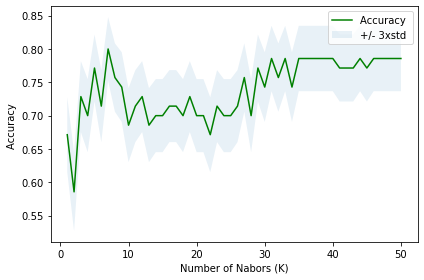

In [64]:
mean_acc=np.zeros(50)
std_acc = np.zeros(50)
for n in range(1,51):
    knnmodel=KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    y_pred=knnmodel.predict(X_test)
    mean_acc[n-1]=metrics.accuracy_score(y_test,y_pred)
    std_acc[n-1]=np.std(y_pred==y_test)/np.sqrt(y_pred.shape[0])
    
plt.plot(range(1,51),mean_acc,'g')
plt.fill_between(range(1,51),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [65]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)


The best accuracy was with 0.8 with k= 7


In [66]:
k = 7
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(n_neighbors=7)

In [67]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([1, 1, 1, 1, 1])

In [70]:
print(f1_score(y_test,yhat))
print(jaccard_score(y_test,yhat))
neigh_probs = neigh.predict_proba(X_test)
score = log_loss(y_test, neigh_probs)
print(score)

0.875
0.7777777777777778
0.46627291112690644


## 2. Decision Trees

In [82]:
from sklearn.tree import DecisionTreeClassifier

In [83]:
dtmodel = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
dtmodel.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [84]:
yhat=dtmodel.predict(X_test)
TreeAccuracy=metrics.accuracy_score(y_test,yhat)
TreeAccuracy

0.6142857142857143

In [85]:
print(f1_score(y_test,yhat))
print(jaccard_score(y_test,yhat))
dtmodel_probs = dtmodel.predict_proba(X_test)
score = log_loss(y_test, dtmodel_probs)
print(score)

0.7272727272727274
0.5714285714285714
1.3752811756372592


## 3. SVM

In [90]:
from sklearn import svm
svmmodel=svm.SVC(kernel='rbf',probability=True)
svmmodel.fit(X_train,y_train)

SVC(probability=True)

In [91]:
yhat=svmmodel.predict(X_test)
yhat

array([0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1])

In [92]:
metrics.accuracy_score(y_test,yhat)

0.7428571428571429

In [93]:
print(f1_score(y_test,yhat))
print(jaccard_score(y_test,yhat))
svmmodel_probs = svmmodel.predict_proba(X_test)
score = log_loss(y_test, svmmodel_probs)
print(score)

0.8421052631578948
0.7272727272727273
0.5178538113483091


## 4. Logistic Regression

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
lrmodel=LogisticRegression(C=0.01,solver='liblinear').fit(X_train,y_train)

In [95]:
yhat=lrmodel.predict(X_test)
print(yhat)
print(lrmodel.predict_proba(X_test))

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]
[[0.50365615 0.49634385]
 [0.45260727 0.54739273]
 [0.30834315 0.69165685]
 [0.34258403 0.65741597]
 [0.32042179 0.67957821]
 [0.31694156 0.68305844]
 [0.48865305 0.51134695]
 [0.47866065 0.52133935]
 [0.34258403 0.65741597]
 [0.49358617 0.50641383]
 [0.33809238 0.66190762]
 [0.49687339 0.50312661]
 [0.24925458 0.75074542]
 [0.34193597 0.65806403]
 [0.43816551 0.56183449]
 [0.25772552 0.74227448]
 [0.52364539 0.47635461]
 [0.30470233 0.69529767]
 [0.50187505 0.49812495]
 [0.31979525 0.68020475]
 [0.44299871 0.55700129]
 [0.49437273 0.50562727]
 [0.51365623 0.48634377]
 [0.47206948 0.52793052]
 [0.40980986 0.59019014]
 [0.50865706 0.49134294]
 [0.51115693 0.48884307]
 [0.37529932 0.62470068]
 [0.5043758  0.4956242 ]
 [0.2532199  0.7467801 ]
 [0.46861859 0.53138141]
 [0.46033929 0.53966071]
 [0.46253832 0.53746168]
 [0.48437417 0.51562583]
 [0.388

In [96]:
metrics.accuracy_score(y_test,yhat)


0.6857142857142857

In [97]:
print(f1_score(y_test,yhat))
print(jaccard_score(y_test,yhat))
lrmodel_probs = lrmodel.predict_proba(X_test)
score = log_loss(y_test, lrmodel_probs)
print(score)

0.8070175438596492
0.6764705882352942
0.5795283132872832


## In summary, comparing F1_scores, best classifier;
## 1. k-nearest with 0.85, 2. SVM with 0.84, 3. Logistic Regression with 0.80, 4. Decision Trees with 0.70
## Comparing jaccard indexes, best classifier;
## 1. k-nearest with 0.77, 2. SVM with 0.72, 3. Logistic Regression with 0.67, 4. Desicion Trees with 0.57
## Comparing log loss, best classifiers;
## 1. k-nearest with 0.46, 2. SVM with 0.51, 3. Logistic Regression with 0.57, 4. Decision Tress with 1.37

# K-nearest with k=7 is the best classifier